### Embed EVUniverse articles for search

Prepared a dataset of EVUniverse Help Articles for search to be used by the   ChatBot.

Procedure:

1. Prerequisites: Import libraries, set API key (if needed)
2. Collect: We cralw the few hundred EVUniverse Help articles from our Website.
3. Chunk: Documents are split into short, semi-self-contained sections to be embedded
4. Embed: Each section is embedded with the OpenAI API
5. Store: Embeddings are saved in a CSV file (for large datasets, use a vector database)
6. Test: Quick Test Q&A to validate that our embeddings work

### 1. Prerequisites: 

Install Libraries, Import libraries, set API key, and select models and tokenizers for embeddings.

#### Install Libraries

```
% pip install --upgrade pip
% pip install git+https://github.com/openai/whisper.git
% pin install playwright
% playwright install
```

In [1]:
# imports

# Authentication
import openai                               # for calling the OpenAI API

# Collect: We crawl the few hundred EVUniverse Help articles from our Website.
import os                                   # for accessing files and Env Variables
import llama_index                          # for crawling/scraping websites
from llama_index import download_loader     # for crawling/scraping websites

# Chunk: Documents are split into short, semi-self-contained sections to be embedded
import pandas as pd                         # for storing text and embeddings data
import tiktoken                             # for counting tokens

# Embed: Each section is embedded with the OpenAI API

# Store: Embeddings are saved in a CSV file (for large datasets, use a vector database)

# Test: Quick Test Q&A to validate that our embeddings work
# import numpy as np                                              # for updatind dataframes in numpy arrays for processing
from openai.embeddings_utils import distances_from_embeddings   # for embedding distance calcuation
# import json


Install any missing libraries with pip install in your terminal. E.g.,
`pip install openai`

(You can also do this in a notebook cell with !pip install openai.)
If you install any libraries, be sure to restart the notebook kernel.

#### Set API Keys

The OpenAI library will try to read your API key from the OPENAI_API_KEY environment variable. If you haven't already,find your [API Key](https://platform.openai.com/account/api-keys), and export your API key in your shell configuration file.

```
echo "export OPENAI_API_KEY='you-api-key'" >> ~/.zshrc
source ~/.zshrc
echo $OPENAI_API_KEY
```

In [2]:
# models, tokenizers & web domains

# Collect: We crawl the few hundred EVUniverse Help articles from our Website.
doc_dir = "../raw_data/"

# Chunk: Documents are split into short, semi-self-contained sections to be embedded
TOKENIZER = "cl100k_base"                   # cl100k_base tokenizer is designed to work with the ada-002 model

# Embed: Each section is embedded with the OpenAI API
EMBEDDING_MODEL = "text-embedding-ada-002"  # OpenAI's best embeddings as of Apr 2023
MAX_TOKENS = 1000                            # Max number of tokens in an embedded data Row, 750 tokens is ~1000 words.

# Store: Embeddings are saved in a CSV file
processed_data_dir = "../processed_data/"

# Testing    
MAX_LEN_OF_SUPPORTING_EVIDENCE = 1800
GPT_MODEL = "gpt-3.5-turbo"
TEST_QUERY = "What does electric car maintenance involve?"
TEMP=0.5
PROMPT="Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\""
URL_PREFIX = "https://www.evuniverse.com/"     #For URL of Supporting Evidence



### 2. Crawl the EVUniverse KB Website
This code will create a new dataset by crawling aka scraping the EVUniverse website 

#### Each crawled document looks something like this:

Home
»
Stay Charged: Your Ultimate Guide to Electric Car Maintenance

Stay Charged: Your Ultimate Guide To Electric Car Maintenance
June 01, 2023
EV Universe
EV Universe
As the wave of electric vehicle (EV) enthusiasm continues to surge, you might be contemplating joining the electric revolution. When we talk about electric car maintenance, we mean the regular checks and care to keep your EV running at its best. Like any vehicle, an electric car needs regular care. However, you’ll be glad to know that maintenance for electric cars tends to be simpler and less frequent than for their gasoline-powered counterparts. With fewer moving parts, electric vehicles skip the need for oil changes, spark plug replacements, or timing belt adjustments – all thanks to the absence of an internal combustion engine.

 

electric car maintenance i7 front pty EVU

 

But don’t be fooled – electric cars aren’t entirely maintenance-free. In this guide, we’re going to delve into everything you need to know about maintaining an electric car. So buckle up, and let’s take this informative ride together!

 

What Is Electric Car Maintenance?
When we talk about electric car maintenance, we’re referring to the regular checks and care needed to keep your electric vehicle (EV) running smoothly and efficiently. Just like with any vehicle, maintenance is crucial. However, the good news for EV owners is that electric car maintenance is usually simpler and less frequent than it is for gasoline-powered vehicles.

 

Electric vehicles have fewer moving parts than their conventional counterparts. Without an internal combustion engine (ICE), there’s no need for oil changes, spark plug replacements, or timing belt adjustments. This makes maintenance for electric cars generally less complex and less frequent compared to ICE cars. If you’re interested in a more in-depth comparison between electric car and ICE car maintenance, we recommend you check out our article on How EV Maintenance Compares to That for ICE Cars.


### 3. Chunk documents

Now that we have our reference documents, we need to prepare them for search. Because GPT can only read a limited amount of text at once, we'll split each document into chunks short enough to be read. This part will include:

- Convert text to pandas dataframe format
- Remove any blank lines from dataframe text and store data in CSV format
- Tokenize the text.
- Split Longer lines into smaller chunks

In [26]:
# Convert text in each file to Pandas dataframe format
# We do this by looping through the text files in the text directory created earlier. After opening each file, 
# remove the extra spacing and append the modified text to a list. Then, add the text with the new lines removed
# to an empty Pandas data frame. Pandas is a popular open source library that helps you work with tabular data 
# (data stored in rows and columns).
   
# Function to remove blank lines because they can clutter the text files and make them harder to embed. 
def remove_newlines(text):
    text = text.str.replace('\n', ' ')
    if (" ".join(text).count('\\n') > 0):
        text = text.str.replace('\\n', ' ')
    text = text.str.replace('  ', ' ')
    return text

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file_name in os.listdir(doc_dir):
    # Open the file and read the text
    try:
        with open(doc_dir + file_name, "r", encoding="UTF-8") as f:
            # print(file_name)
            text = f.read()            
            texts.append((file_name, text))
    
    except FileNotFoundError:
        print('no such file:', file_name)
    except Exception as e: #handle other exceptions such as attribute errors
        print ("Unexpected error with file:", file_name, e)

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['title', 'text'])


# Set the text column to be the raw text with the newlines removed
df['text'] = remove_newlines(df.text)
df.head()

Unexpected error with file: .ipynb_checkpoints [Errno 21] Is a directory: '../raw_data/.ipynb_checkpoints'


,title,text
0,are-public-ev-charge-stations-free.txt,Home » Are Public EV Charge Stations Free? Are...
1,gmc-hummer-ev-review.txt,Home » GMC Hummer EV Review GMC Hummer EV Revi...
2,ford-evs-gain-access-to-tesla-superchargers.txt,Home » Ford EVs Gain Access to Tesla Superchar...
3,lexus-rz-ev-profile.txt,"Home » Lexus RZ Review Lexus RZ Review May 05,..."
4,stay-charged-your-ultimate-guide-to-electric-c...,Home » Stay Charged: Your Ultimate Guide to El...


In [27]:
# Create a directory to store the data frame in csv format.
if not os.path.exists(processed_data_dir):
    os.mkdir(processed_data_dir)
            
df.to_csv(processed_data_dir + '/scraped.csv')

In [28]:
# Tokenize the text in CSV files
# Tokenization is the next step after saving the raw text into a CSV file. chatGPT API has a limit on the maximum
# number of input tokens for embeddings. To stay below the limit, the text in the CSV file needs to be broken down
# into multiple rows. The existing length of each row will be recorded first to identify which rows need to be split.
# This process splits the input text into tokens by breaking down the sentences and words. 

# A helpful rule of thumb is that one token generally corresponds to ~4 characters of text for common English text. 
# This translates to roughly ¾ of a word (so 100 tokens ~= 75 words). 

# Load the tokenizer that is compatible with the embedding model
tokenizer = tiktoken.get_encoding(TOKENIZER)

df = pd.read_csv(processed_data_dir + '/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.head()

,title,text,n_tokens
0,are-public-ev-charge-stations-free.txt,Home » Are Public EV Charge Stations Free? Are...,2122
1,gmc-hummer-ev-review.txt,Home » GMC Hummer EV Review GMC Hummer EV Revi...,1732
2,ford-evs-gain-access-to-tesla-superchargers.txt,Home » Ford EVs Gain Access to Tesla Superchar...,727
3,lexus-rz-ev-profile.txt,"Home » Lexus RZ Review Lexus RZ Review May 05,...",2054
4,stay-charged-your-ultimate-guide-to-electric-c...,Home » Stay Charged: Your Ultimate Guide to El...,1799


<Axes: >

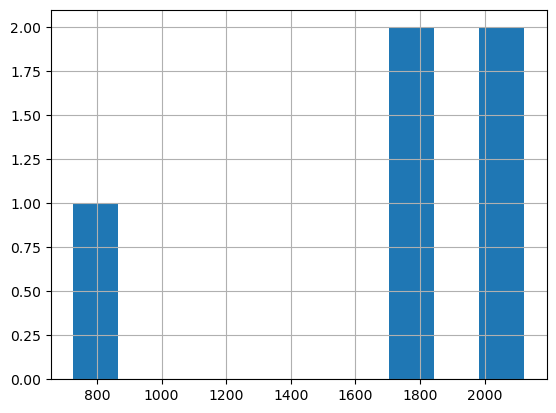

In [29]:
# Visualize the distribution of the number of tokens per row using a histogram
# X Axis is the Number of Rows
# Y Axis is the Number of Tokens
df.n_tokens.hist()

In [30]:
# Split Longer lines into smaller chunks
# The newest embeddings model can handle inputs with up to 8191 input tokens and as per the histogram above, the max
# tokens we have in a row is less than 5000, so most of the rows would not need any chunking.
# But this may not be the case for every document scraped in the future so the next code chunk will split the 
# longer lines into smaller chunks.

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = MAX_TOKENS):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():
    
    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # Extract Title
    title = row[1]['title']
    # print("Title is: ", title)  # For debug purpose

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > MAX_TOKENS:
        single_chunks = []
        tuple_chunks = []
        single_chunks = split_into_many(row[1]['text'])
        
        # Loop through the chunks
        for text in single_chunks:
            tuple_chunks.append((title, text))
        
        shortened += tuple_chunks
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append((title, row[1]['text']))

# Update the dataframe
df = pd.DataFrame(shortened, columns = ['title', 'text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.head()

Title is:  are-public-ev-charge-stations-free.txt
Title is:  gmc-hummer-ev-review.txt
Title is:  ford-evs-gain-access-to-tesla-superchargers.txt
Title is:  lexus-rz-ev-profile.txt
Title is:  stay-charged-your-ultimate-guide-to-electric-car-maintenance.txt


,title,text,n_tokens
0,are-public-ev-charge-stations-free.txt,Home » Are Public EV Charge Stations Free? Are...,997
1,are-public-ev-charge-stations-free.txt,"Level 2 charging is the happy medium, offeri...",985
2,gmc-hummer-ev-review.txt,Home » GMC Hummer EV Review GMC Hummer EV Revi...,979
3,ford-evs-gain-access-to-tesla-superchargers.txt,Home » Ford EVs Gain Access to Tesla Superchar...,727
4,lexus-rz-ev-profile.txt,"Home » Lexus RZ Review Lexus RZ Review May 05,...",994


<Axes: >

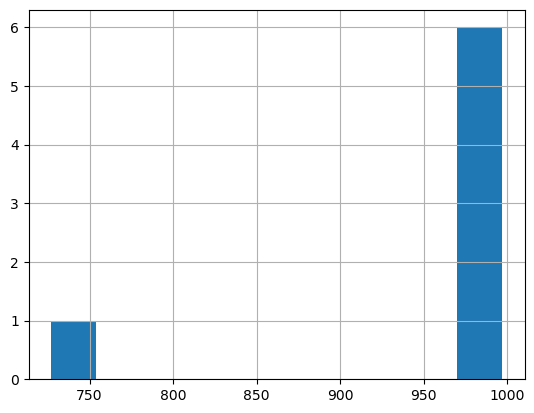

In [31]:
# Visualize the updated histogram again to confirm if the rows were successfully split into shortened sections.
df.n_tokens.hist()

### 4. Embed Document Chunks
A simple request is sent to the OpenAI API specifying the use of the new text-embedding-ada-002 model to create the embeddings.  This should take about 3-5 minutes but after you will have your embeddings ready to use!

In [32]:
# calculate embeddings
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine=EMBEDDING_MODEL)['data'][0]['embedding'])
df.head()

,title,text,n_tokens,embeddings
0,are-public-ev-charge-stations-free.txt,Home » Are Public EV Charge Stations Free? Are...,997,"[0.03615858778357506, -0.01933480054140091, 0...."
1,are-public-ev-charge-stations-free.txt,"Level 2 charging is the happy medium, offeri...",985,"[0.029253272339701653, 0.0022631052415817976, ..."
2,gmc-hummer-ev-review.txt,Home » GMC Hummer EV Review GMC Hummer EV Revi...,979,"[0.014182053506374359, -0.02596406638622284, 0..."
3,ford-evs-gain-access-to-tesla-superchargers.txt,Home » Ford EVs Gain Access to Tesla Superchar...,727,"[0.009190221317112446, -0.03851385787129402, -..."
4,lexus-rz-ev-profile.txt,"Home » Lexus RZ Review Lexus RZ Review May 05,...",994,"[0.01976274885237217, -0.010187925770878792, -..."


### 5. Store document chunks and embeddings
Because this example only uses a few thousand strings, we'll store them in a CSV file.
(For larger datasets, use a vector database, which will be more performant.)

In [33]:
df.to_csv(processed_data_dir + '/embeddings.csv')

### 6. Quick Test Q&A to validate that our embeddings work.
Take a simple question, create an embedding of it, compare it with the existing embeddings of our KB, retrieve the most relevant text based on the embedding value.

- Turn the KB embeddings into a NumPy array.
- Get the Embedding value of the question.
- Identify Supporting Evidence to answer the question based on Embedding
- Answer the Question


**Explaination**
This will take a user's question, create an embedding of it, and compare it with the existing embeddings to retrieve the most relevant text from the scraped website. 

- **Turn the chunks with embedding data into a NumPy array.** 
    - When you first read from the CSV file, the original embedded value might be one large string of 34411 chars.
    - The df.apply(eval) step turns that string into an array of 1536 floats.
    - The df.apply(np.array) flattens the array dimension to 1-D, which is the required format for many subsequent operations. 
    - The NumPy array could also provide more flexibility in how to use the data given the many functions available that operate on NumPy arrays. 
- **Get the embedding value of the question**
- **Identify Supporting Evidence to answer the question based on Embedding**.  The search with embeddings compares the vector of numbers (which was the conversion of the raw text) using cosine distance. The vectors are likely related and might be the answer to the question if they are close in cosine distance. 

In [39]:
# Load the Embeddings File into a Data Frame
df=pd.read_csv(processed_data_dir + '/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval)
df.head()

# Get the embedding value of the query
q_embeddings = openai.Embedding.create(input=TEST_QUERY, engine=EMBEDDING_MODEL)['data'][0]['embedding']

# Identify Supporting Evidence to answer the question based on Embedding
max_len=MAX_LEN_OF_SUPPORTING_EVIDENCE

df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')

source_texts = []
source_urls = []
cur_len = 0

# Sort by distance and add the text to the context until the context is too long
for i, row in df.sort_values('distances', ascending=True).iterrows():
    # Add the length of the text to the current length
    cur_len += row['n_tokens'] + 4
        
    # If the context is too long, break
    if cur_len > max_len:
        break
        
    # Else add it to the text that is being returned
    source_texts.append(row['text'])
    source_urls.append(URL_PREFIX + row['title'].strip(".txt"))
    

# Update supporting evidence
suporting_evidence = "\n\n###\n\n".join(source_texts)
suporting_evidence_urls = "\n".join(source_urls)

# Answer the Question
try:
    response = openai.ChatCompletion.create(
        temperature=TEMP,
        model=GPT_MODEL,
        top_p=1,
        stop=None,
        max_tokens=MAX_TOKENS,
        frequency_penalty=0,
        presence_penalty=0,
        messages=[
            {"role": "system", "content": PROMPT + "\n\nsuporting_evidence: " + str(suporting_evidence) + "\n\n---\n\n"}, 
            {"role": "user", "content": TEST_QUERY}
        ]
    )     
    print("Question: ", TEST_QUERY, "\n")
    print("Answer: ", response.choices[0].message['content'], "\n\n")
    print("URLs For Further Refernce:\n", suporting_evidence_urls, "\n\n")
    
    print("\n### DEBUG ###\n")
    print("Prompt: ", PROMPT, "\n")        
    print("Raw Model Response:\n", response.choices[0].message, "\n")        
    print("Suporting Evidence:\n" + suporting_evidence)
    print("\n\n")

except Exception as e:
    print("\n\n Exception: ", e, "\n")

Question:  What does electric car maintenance involve? 

Answer:  Electric car maintenance involves regular checks and care needed to keep an electric vehicle running smoothly and efficiently. This includes tasks such as monitoring battery health, checking tire pressure, maintaining the brake system, and regular cooling system checks. Additionally, keeping the software up to date and paying attention to the electric car charging equipment is also important. 


URLs For Further Refernce:
 https://www.evuniverse.com/stay-charged-your-ultimate-guide-to-electric-car-maintenance 



### DEBUG ###

Prompt:  Answer the question based on the context below, and if the question can't be answered based on the context, say "I don't know" 

Raw Model Response:
 {
  "content": "Electric car maintenance involves regular checks and care needed to keep an electric vehicle running smoothly and efficiently. This includes tasks such as monitoring battery health, checking tire pressure, maintaining the bra